In [1]:
#IMPORTS
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image
%matplotlib inline


In [2]:
#Using VGG-19 pretrained model for image classification
model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [4]:
#Print the structure of the model
#Input: B * C * H * W
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, (3, 224, 224),1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [5]:
res_path = '/home/zhuangzhigao/Desktop/MalteseDog.jpg'

In [6]:
from PIL import Image
img = Image.open(res_path)

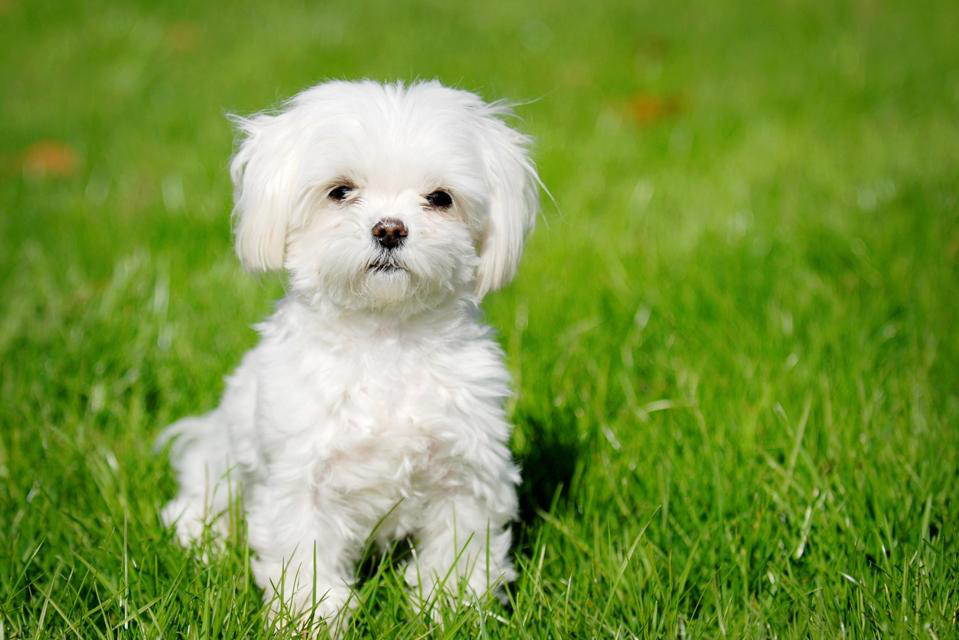

In [7]:
display(img)

In [8]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)


In [21]:
# Preprocess the image
X = preprocess(img)
X = X.to(device)

# Run the model in evaluation mode
model.eval()

# Find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model(X)

score_max_index = scores.argmax()
print(score_max_index)

score_max = scores[0,score_max_index]
print(score_max)

# Get the index corresponding to the maximum score and the maximum score itself.




tensor(153, device='cuda:0')
tensor(21.7797, device='cuda:0', grad_fn=<SelectBackward>)


In [22]:
'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph

'''
score_max.backward()

In [41]:
'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''

saliency, _ = torch.max(X.grad.data.abs(),dim=1)


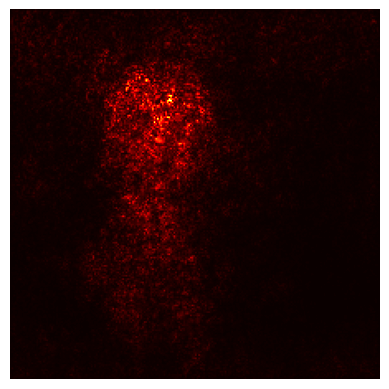

In [44]:
# code to plot the saliency map as a heatmap
plt.imshow(saliency.data.cpu().numpy()[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()